# Multiclass Support Vector Machine exercise
(Adapted from Stanford University's CS231n Open Courseware)

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [HW page](http://kovan.ceng.metu.edu.tr/~sinan/DL/index.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [3]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CIFAR-10 Data Loading and Preprocessing

In [4]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir, num_of_batches=6)
# Increase num_of_batches to 6 if you have sufficient memory

# As a sanity check, we print out the size of the training and test data.
print(X_train.shape)
print('Training data shape: {}'.format(X_train.shape))
print('Training labels shape: {}'.format(y_train.shape))
print('Test data shape: {}'.format(X_test.shape))
print('Test labels shape: {}'.format(y_test.shape))
a = [[12, 32, 32], [2, 3, 4]]
print(np.sum(a, axis=1))
print(np.sum(a, axis=0))

(50000, 32, 32, 3)
Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000,)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000,)
[76  9]
[14 35 36]


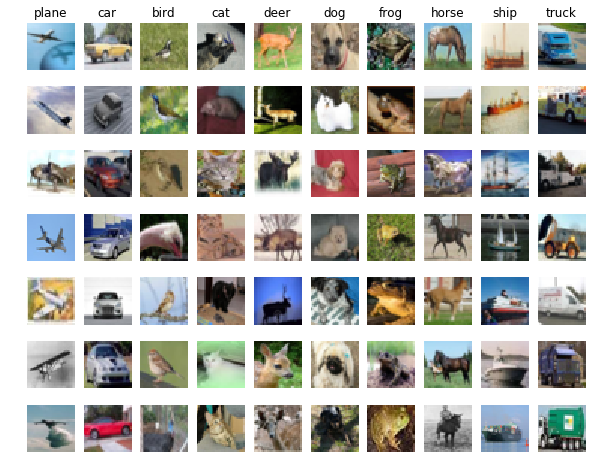

(50000, 32, 32, 3)


In [267]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()
print(X_train.shape)

In [268]:
# Subsample the data for more efficient code execution in this exercise.
num_training = 18000
#Increase this if you have memory: num_training = 49000
num_validation = 1000
num_test = 1000
# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: {}, '.format(X_train.shape))
print('Train labels shape: {}'.format(y_train.shape))
print('Validation data shape: {}'.format(X_val.shape))
print('Validation labels shape: {}'.format(y_val.shape))
print('Test data shape: {}'.format(X_test.shape))
print('Test labels shape: {}'.format(y_test.shape))

Train data shape: (18000, 32, 32, 3), 
Train labels shape: (18000,)
Validation data shape: (1000, 32, 32, 3)
Validation labels shape: (1000,)
Test data shape: (1000, 32, 32, 3)
Test labels shape: (1000,)


In [269]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: {}'.format(X_train.shape))
print('Validation data shape: {}'.format(X_val.shape))
print('Test data shape: {}'.format(X_test.shape))

Training data shape: (18000, 3072)
Validation data shape: (1000, 3072)
Test data shape: (1000, 3072)


[ 131.30172222  136.29311111  132.64966667  130.66894444  135.65122222
  131.91416667  131.57355556  136.43027778  132.59827778  132.14788889]


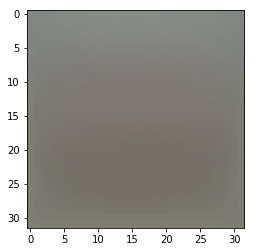

In [270]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image

In [271]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

In [272]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
# Also, lets transform both data matrices so that each image is a column.
print(X_train.shape, X_train.shape[0])

X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]).T
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))]).T
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))]).T

print(X_train.shape, X_val.shape, X_test.shape)

(18000, 3072) 18000
(3073, 18000) (3073, 1000) (3073, 1000)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [302]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
from cs231n.classifiers.linear_svm import svm_loss_vectorized
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(10, 3073) * 0.0001 
loss, grad = svm_loss_naive(W, X_train, y_train, 0.00001)
print('loss: {:f}'.format(loss))

loss: 8.722255


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [303]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_train, y_train, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_train, y_train, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -17.530711 analytic: -17.528459, relative error: 6.422288e-05
numerical: -11.748683 analytic: -11.745635, relative error: 1.297741e-04
numerical: 24.651382 analytic: 24.654004, relative error: 5.318509e-05
numerical: 5.742449 analytic: 5.742449, relative error: 6.561937e-11
numerical: 40.876055 analytic: 40.876145, relative error: 1.102434e-06
numerical: 8.388808 analytic: 8.389601, relative error: 4.725024e-05
numerical: -12.697292 analytic: -12.700224, relative error: 1.154399e-04
numerical: -0.165713 analytic: -0.168858, relative error: 9.399310e-03
numerical: -16.933865 analytic: -16.931281, relative error: 7.630529e-05
numerical: 12.822068 analytic: 12.819297, relative error: 1.080676e-04


**Inline Question 1:**
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** Yes that is possible. SVM loss is not differentiable at point zero, so there is no real gradient at 0. Numerical gradient when computed does a finite approximations, fails to check 0.

In [304]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_train, y_train, 0.00001)
toc = time.time()
print('Naive loss: {:e} computed in {:f}s'.format(loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_train, y_train, 0.00001)
toc = time.time()
print('Vectorized loss: {:e} computed in {:f}s'.format(loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: {:f}'.format(loss_naive - loss_vectorized))

Naive loss: 8.722255e+00 computed in 3.683127s
Vectorized loss: 8.722250e+00 computed in 0.207116s
difference: 0.000005


In [305]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_train, y_train, 0.00001)
toc = time.time()
print('Naive loss and gradient: computed in {:f}s'.format(toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_train, y_train, 0.00001)
toc = time.time()
print('Vectorized loss and gradient: computed in {:f}s'.format(toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: {:f}'.format(difference))

Naive loss and gradient: computed in 3.814012s
Vectorized loss and gradient: computed in 0.225815s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [306]:
# Now implement SGD in LinearSVM.train() function and run it with the code below
from cs231n.classifiers.linear_classifier import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took {:f}s'.format(toc - tic))

iteration 0 / 1500: loss 782.733080
iteration 100 / 1500: loss 285.667080
iteration 200 / 1500: loss 107.619630
iteration 300 / 1500: loss 42.112410
iteration 400 / 1500: loss 19.183930
iteration 500 / 1500: loss 10.125260
iteration 600 / 1500: loss 7.011700
iteration 700 / 1500: loss 6.372140
iteration 800 / 1500: loss 5.538130
iteration 900 / 1500: loss 5.561090
iteration 1000 / 1500: loss 5.366460
iteration 1100 / 1500: loss 5.605680
iteration 1200 / 1500: loss 5.150150
iteration 1300 / 1500: loss 5.400430
iteration 1400 / 1500: loss 5.305540
That took 11.975608s


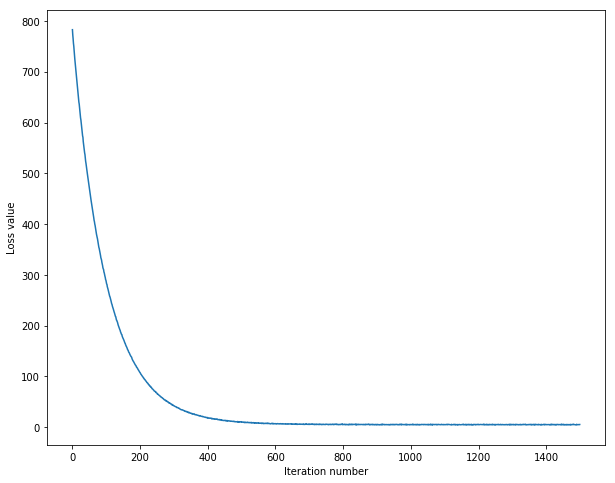

In [307]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')

In [308]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: {:f}'.format(np.mean(y_train == y_train_pred)))
y_val_pred = svm.predict(X_val)
print('validation accuracy: {:f}'.format(np.mean(y_val == y_val_pred)))

training accuracy: 0.377611
validation accuracy: 0.380000


In [318]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
from collections import OrderedDict
from operator import itemgetter
learning_rates = [1e-7, 1e-6, 1e-5, 1e-8, 1e-9, 1e-3, 1]
regularization_strengths = [5e4, 3e4, 2e4, 1e4, 1e2, 1, 1e6, 1e4, 1e3]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.
results = {}
best_val = -1
best_svm = None
for rates in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train, y_train, rates, reg, num_iters=1500, verbose=True)
        y_pred_train = svm.predict(X_train)
        y_pred_val = svm.predict(X_val)
        results[(rates, reg)] = (np.mean(y_train == y_pred_train), np.mean(y_val == y_pred_val))
        sorted_list = OrderedDict(sorted(results.items(), key=itemgetter(1), reverse=True)) 
        new_best = list(sorted_list.values())[0]
        best_params = list(sorted_list.keys())[0]
        if(best_val<new_best[1]):
            best_val = new_best[1]
            best_svm = svm
        ################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
svm.best(best_val, best_svm)
pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for (lr, reg) in sorted_list.keys():
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr {:e} reg {:e} train accuracy: {:f} val accuracy: {:f}'.format(
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: {:f}'.format(best_val))

iteration 0 / 1500: loss 776.539120
iteration 100 / 1500: loss 283.646670
iteration 200 / 1500: loss 106.495710
iteration 300 / 1500: loss 41.367720
iteration 400 / 1500: loss 18.684550
iteration 500 / 1500: loss 9.862300
iteration 600 / 1500: loss 7.277570
iteration 700 / 1500: loss 5.874810
iteration 800 / 1500: loss 4.942400
iteration 900 / 1500: loss 5.715620
iteration 1000 / 1500: loss 5.662290
iteration 1100 / 1500: loss 5.634070
iteration 1200 / 1500: loss 5.337320
iteration 1300 / 1500: loss 4.992350
iteration 1400 / 1500: loss 5.206510
iteration 0 / 1500: loss 489.043960
iteration 100 / 1500: loss 264.575120
iteration 200 / 1500: loss 145.387380
iteration 300 / 1500: loss 81.642050
iteration 400 / 1500: loss 46.268220
iteration 500 / 1500: loss 27.389450
iteration 600 / 1500: loss 17.234370
iteration 700 / 1500: loss 12.311280
iteration 800 / 1500: loss 8.776320
iteration 900 / 1500: loss 6.857270
iteration 1000 / 1500: loss 6.390110
iteration 1100 / 1500: loss 5.435430
iterat

iteration 1400 / 1500: loss 3.822200
iteration 0 / 1500: loss 15374.106140
iteration 100 / 1500: loss 19.590060
iteration 200 / 1500: loss 17.568140
iteration 300 / 1500: loss 17.185300
iteration 400 / 1500: loss 16.982200
iteration 500 / 1500: loss 17.300130
iteration 600 / 1500: loss 15.001820
iteration 700 / 1500: loss 14.823350
iteration 800 / 1500: loss 18.398180
iteration 900 / 1500: loss 19.269420
iteration 1000 / 1500: loss 17.756000
iteration 1100 / 1500: loss 14.586050
iteration 1200 / 1500: loss 14.107850
iteration 1300 / 1500: loss 16.176210
iteration 1400 / 1500: loss 19.696360
iteration 0 / 1500: loss 176.495720
iteration 100 / 1500: loss 26.218010
iteration 200 / 1500: loss 9.003300
iteration 300 / 1500: loss 5.760190
iteration 400 / 1500: loss 5.248820
iteration 500 / 1500: loss 6.230700
iteration 600 / 1500: loss 5.915740
iteration 700 / 1500: loss 6.695370
iteration 800 / 1500: loss 6.344380
iteration 900 / 1500: loss 5.478040
iteration 1000 / 1500: loss 5.317210
iter

/Users/alisa/Desktop/HW1_for_students/cs231n/classifiers/linear_svm.py:80: RuntimeWarning: overflow encountered in multiply
  #compute loss
/Users/alisa/Desktop/HW1_for_students/cs231n/classifiers/linear_svm.py:80: RuntimeWarning: overflow encountered in double_scalars
  #compute loss


iteration 200 / 1500: loss inf
iteration 300 / 1500: loss inf


/Users/alisa/Desktop/HW1_for_students/cs231n/classifiers/linear_svm.py:85: RuntimeWarning: overflow encountered in multiply
  margin[range(X.shape[1]), y] = (-np.sum(margin, axis=1)).T
/Users/alisa/Desktop/HW1_for_students/cs231n/classifiers/linear_svm.py:82: RuntimeWarning: invalid value encountered in greater
  #replace > 0 values by one, to compute bradient in the next step
/Users/alisa/Desktop/HW1_for_students/cs231n/classifiers/linear_classifier.py:52: RuntimeWarning: invalid value encountered in subtract
  self.W-=learning_rate*grad


iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 174.044480
iteration 100 / 1500: loss 26.598250
iteration 200 / 1500: loss 39.458310
iteration 300 / 1500: loss 48.637530
iteration 400 / 1500: loss 45.469170
iteration 500 / 1500: loss 22.899570
iteration 600 / 1500: loss 46.725590
iteration 700 / 1500: loss 32.192950
iteration 800 / 1500: loss 44.994030
iteration 900 / 1500: loss 33.290780
iteration 1000 / 1500: loss 39.743050
iteration 1100 / 1500: loss 26.483030
iteration 1200 / 1500: loss 21.168080
iteration 1300 / 1500: loss 46.692920
iteration 1400 / 1500: loss 32.816610
iteration 0 / 1500: loss 41.471640
iteration 100 / 1500: loss 24.667540
iteration 200 / 1500: l

iteration 1300 / 1500: loss 309.802400
iteration 1400 / 1500: loss 308.793920
iteration 0 / 1500: loss 175.773250
iteration 100 / 1500: loss 173.811610
iteration 200 / 1500: loss 173.194410
iteration 300 / 1500: loss 171.778940
iteration 400 / 1500: loss 170.220740
iteration 500 / 1500: loss 172.924350
iteration 600 / 1500: loss 169.758290
iteration 700 / 1500: loss 170.372320
iteration 800 / 1500: loss 170.405400
iteration 900 / 1500: loss 167.530210
iteration 1000 / 1500: loss 168.496330
iteration 1100 / 1500: loss 167.835920
iteration 1200 / 1500: loss 167.772260
iteration 1300 / 1500: loss 165.552520
iteration 1400 / 1500: loss 166.140710
iteration 0 / 1500: loss 22.793550
iteration 100 / 1500: loss 24.750400
iteration 200 / 1500: loss 21.567150
iteration 300 / 1500: loss 22.483310
iteration 400 / 1500: loss 20.810580
iteration 500 / 1500: loss 18.903970
iteration 600 / 1500: loss 23.317780
iteration 700 / 1500: loss 21.359020
iteration 800 / 1500: loss 21.275440
iteration 900 / 15

/Users/alisa/Desktop/HW1_for_students/cs231n/classifiers/linear_svm.py:74: RuntimeWarning: overflow encountered in subtract
  # compute the Loss function
/Users/alisa/Desktop/HW1_for_students/cs231n/classifiers/linear_svm.py:74: RuntimeWarning: invalid value encountered in subtract
  # compute the Loss function


iteration 200 / 1500: loss nan
iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 489.756310
iteration 100 / 1500: loss 21884950421146885617224859935308646191639583008781891840163453183165691605679426963851271022355651038882919680147118341297434065548676722913149087906388046617472871390434343899291257076369298386467417162285179160698525944348314620288744440058876491054821188155208708221451052237206065645575208960.000000
iteration 200 / 1500: loss inf
iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteratio

iteration 800 / 1500: loss 10998066.436130
iteration 900 / 1500: loss 14979001.977950
iteration 1000 / 1500: loss 11769691.143640
iteration 1100 / 1500: loss 9682552.595290
iteration 1200 / 1500: loss 10141108.722170
iteration 1300 / 1500: loss 11981472.103050
iteration 1400 / 1500: loss 11681391.758770
iteration 0 / 1500: loss 15215.287790
iteration 100 / 1500: loss nan
iteration 200 / 1500: loss nan
iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 171.427570
iteration 100 / 1500: loss nan
iteration 200 / 1500: loss nan
iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss 

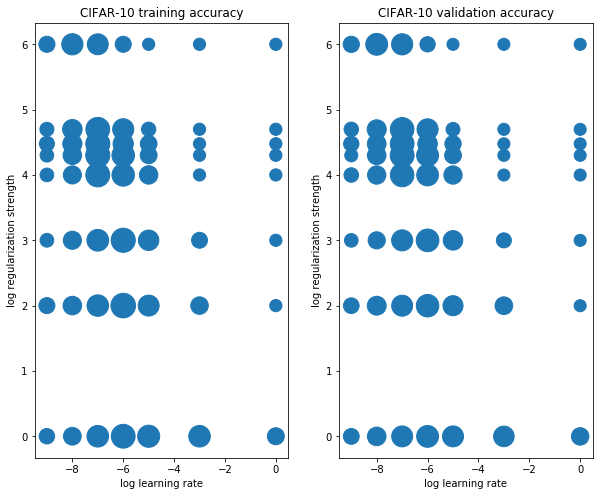

In [319]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
sz = [results[x][0]*1500 for x in results] # default size of markers is 20
plt.subplot(1,2,1)
plt.scatter(x_scatter, y_scatter, sz)
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
sz = [results[x][1]*1500 for x in results] # default size of markers is 20
plt.subplot(1,2,2)
plt.scatter(x_scatter, y_scatter, sz)
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')

In [320]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: {:f}'.format(test_accuracy))

linear SVM on raw pixels final test set accuracy: 0.386000


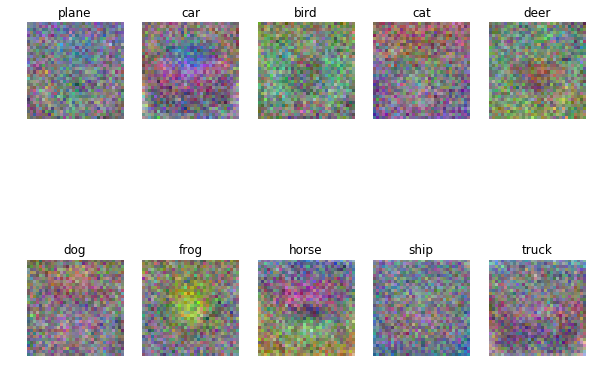

In [322]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:,:-1] # strip out the bias
w = w.reshape(10, 32, 32, 3)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** They are seem to be a merge of different objects in one class, classifier with this parameters tries to find the representative pattern for each class. But it fails too, as weights are noisy what means that selected configuration of the model causes a high bias, we use linear svm, which is a bad fit for our problem.

In [323]:
#TODO: Try to use svm with rbf kernel.